Bonus Assignment - Fabian Härtel - 31.03.2023

In [ ]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

(1) Import all csv files, without the meta data files

In [32]:
dir_path = './data'
csv_file_names = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.find('.csv') != -1:
            csv_file_names.append(path)

(1) Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [33]:
list_df = []
sensor_names = []

for filename in csv_file_names:
    df = pd.read_csv('./data/' + filename, index_col=None, header=0)
    df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)

    sensor_names.append(filename[12:16])
    df.rename(columns={'dt_sound_level_dB': filename[12:16]}, inplace=True)
    list_df.append(df)

list_len = [len(df) for df in list_df]

(1) Remove all measurements with a timestamp not inbetween 2022.02.20 00:00:00 to 2022.03.04 24:00:00, set the timestamp as index of the dataframe, and add the start and end timestamp of the measurement period to the dataframe it doesn’t exist

In [34]:
start_time = datetime.strptime('2022.02.20 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.03.05 00:00:00', '%Y.%m.%d %H:%M:%S')

df_counter = 0

for df in list_df:
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]

    start_row = pd.DataFrame({'Time': start_time, 'dt_sound_level_dB': df.iloc[0][sensor_names[df_counter]]}, index=[0])
    start_row['Time'] = pd.to_datetime(start_row['Time'])

    end_row = pd.DataFrame({'Time': end_time, sensor_names[df_counter]: df.iloc[-1][sensor_names[df_counter]]}, index=[0])
    end_row['Time'] = pd.to_datetime(end_row['Time'])

    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')

    if not (df.index == end_time).any():
        df.loc[end_time] = [df.iloc[-1][sensor_names[df_counter]]]

    if not (df.index == start_time).any():
        df.loc[start_time] = [df.iloc[0][sensor_names[df_counter]]]

    df = df.sort_values(by='Time')
    df_counter += 1

(1) Convert the time series to equally-spaced data with one minute time intervals and interpolate missing data with the “nearest” interpolant. Therefore, let’s insert all missing timestamps first, join existing measurements and finally interpolate missing values.

In [35]:
import datetime

dt = start_time
step = datetime.timedelta(minutes=1)
result = []

while dt < end_time:
    result.append(dt.strftime('%Y.%m.%d %H:%M:%S'))
    dt += step

col = {'Time': result, 'dummy': 0}
df_all_timestamps = pd.DataFrame(data=col)
df_all_timestamps['Time'] = pd.to_datetime(df_all_timestamps['Time'])
df_all_timestamps = df_all_timestamps.set_index('Time')

(1) Interpolate missing data and merge all stations into one dataframe (increase rank)

In [36]:
list_df_inter = []
df_counter = 0
df_final = df_all_timestamps.drop('dummy', axis=1)
for df in list_df:
    df = df_all_timestamps.merge(df, how='left', on='Time')
    df = df.drop('dummy', axis=1)
    while df[sensor_names[df_counter]].isnull().values.any():
        df = df.interpolate(method='bfill', limit=1)
        df = df.interpolate(method='ffill', limit=1)
    df = df.set_index('Time')
    df = df.resample('1T').mean()
    df_counter += 1
    df_final = df_final.merge(df, how='left', on='Time')

(2) Calculate the RMSE as a function of rank against the resampled data for each station.

In [37]:
def calc_SVD_RMSE(df):
    U, s, Vt = np.linalg.svd(df)

    rank_range = range(1, len(df.columns) + 1)
    rmse_list = []
    amount_sing_values = []

    for rank in rank_range:
        Sigma = np.zeros((df.shape[0], df.shape[1]))
        Sigma[:rank, :rank] = np.diag(s[:rank])
        df_recon = U.dot(Sigma.dot(Vt))

        rmse = np.sqrt(np.mean((df - df_recon)**2))
        rmse_list.append(rmse.mean())
        amount_sing_values.append(Sigma[rank-1][rank-1])

    return rmse_list, amount_sing_values

In [38]:
df_final.reset_index(inplace=True)
df_without_timestamp = df_final.iloc[:, 1:len(df_final.columns)+1]

rmse_list, amount_sing_values = calc_SVD_RMSE(df_without_timestamp)

for rank in range(len(rmse_list)):
        print(f'Rank: {rank+1} RMSE: {rmse_list[rank]} Singular Values: {amount_sing_values[rank]}')

Rank: 1 RMSE: 4.6013019123355905 Singular Values: 27810.730654658044
Rank: 2 RMSE: 3.8962666279284566 Singular Values: 1173.9686090715468
Rank: 3 RMSE: 3.3526110718480258 Singular Values: 941.9186669047672
Rank: 4 RMSE: 2.989200343043782 Singular Values: 723.2205197798484
Rank: 5 RMSE: 2.632973959228933 Singular Values: 635.2335900240004
Rank: 6 RMSE: 2.347354118586097 Singular Values: 556.9427924870957
Rank: 7 RMSE: 2.05222157446194 Singular Values: 539.1750154901397
Rank: 8 RMSE: 1.756011792028251 Singular Values: 496.68522063943027
Rank: 9 RMSE: 1.4581040550804072 Singular Values: 474.7835211743438
Rank: 10 RMSE: 0.9809722250975536 Singular Values: 461.4052222116812
Rank: 11 RMSE: 0.5483573918622369 Singular Values: 442.66142655047537
Rank: 12 RMSE: 1.737815312278924e-13 Singular Values: 386.81693818812164


(3) Calculate the ensemble average SPL and substract it from each individual station

In [39]:
df_without_timestamp_sub = df_without_timestamp.sub(df_without_timestamp.mean(axis=1), axis=0)

(3) Rerun steps 1 and 2

In [40]:
rmse_list_sub, amount_sing_values_sub = calc_SVD_RMSE(df_without_timestamp_sub)

for rank in range(len(rmse_list_sub)):
    print(f'Rank: {rank+1} RMSE: {rmse_list[rank]} Singular Values: {amount_sing_values_sub[rank]}')

Rank: 1 RMSE: 4.6013019123355905 Singular Values: 1599.0686176096403
Rank: 2 RMSE: 3.8962666279284566 Singular Values: 942.6071177153432
Rank: 3 RMSE: 3.3526110718480258 Singular Values: 731.2001008219404
Rank: 4 RMSE: 2.989200343043782 Singular Values: 655.2860325641167
Rank: 5 RMSE: 2.632973959228933 Singular Values: 583.8485751297882
Rank: 6 RMSE: 2.347354118586097 Singular Values: 545.5862849947379
Rank: 7 RMSE: 2.05222157446194 Singular Values: 503.4981814672266
Rank: 8 RMSE: 1.756011792028251 Singular Values: 491.3471181896827
Rank: 9 RMSE: 1.4581040550804072 Singular Values: 467.61812100684233
Rank: 10 RMSE: 0.9809722250975536 Singular Values: 455.21866494951354
Rank: 11 RMSE: 0.5483573918622369 Singular Values: 403.079040949816
Rank: 12 RMSE: 1.737815312278924e-13 Singular Values: 4.178381678000011e-12


Lower the Singular values of Rank 1 to being able to plot a better graph

In [41]:
amount_sing_values[0] = amount_sing_values[0] / 10

(4) Plot the singular values and the RMSE (dual y-axes) versus the rank (x-axis) for all stations.

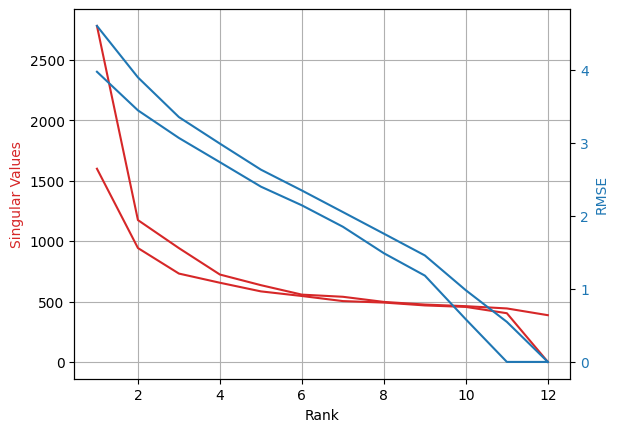

In [44]:
rank_range = range(1, len(df_final.columns))

fig, ax1 = plt.subplots()

colory1 = 'tab:red'
ax1.set_xlabel('Rank')
ax1.set_ylabel('Singular Values', color=colory1)
ax1.plot(rank_range, amount_sing_values, color=colory1)
ax1.plot(rank_range, amount_sing_values_sub, color=colory1)

ax2 = ax1.twinx()

colory2 = 'tab:blue'
ax2.set_ylabel('RMSE', color=colory2)
ax2.plot(rank_range, rmse_list, color=colory2)
ax2.plot(rank_range, rmse_list_sub, color=colory2)
ax2.tick_params(axis='y', labelcolor=colory2)

ax1.grid(True)
ax2.grid(False)

plt.show()

(4) What does this relationship tell you about how much the data can be compressed using SVD?
--> A higher RMSE means that more information is lost due to compressing the data using a SVD. By increasing the rank we can decrease the RMSE and therefore obtain more of the initial information.

(5) What is the physical interpretation of the U, Σ and V matrices from the SVD of the Tallinn SPL data?

U: Set of orthogonal basis vectors which capture spatial patterns in the sound pressure level across the different stations

Σ: Contains singular values / importance of each basis vector (U) and capture the overall variation in the sound pressure levels. A larger singular value means indicates that the corresponding basis vector of U is more important

V: Capture the temporal patterns of the SPL